<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/%5BKI-Lab2021%5D%20Assignment%201%20OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment:
Preparation:
1. Checkout the notebook 0_Simple_NN.ipynb from Git, which describes how to
setup a simple feedforward network on some fake data. Try to understand
everything and execute the notebook. Ask on the chat if sth. is unclear.
2. Read through this blog post: https://nextjournal.com/gkoehler/pytorch-mnist
It shows how to work with data loaders, how to load the MNIST dataset and how
training is done in batches (using data loaders). 

Task:
1. Load the MNIST dataset into train and test data loaders. Use the same
parameters and apply the same transformations like described in the blog post.
2. Create a feedforward neural network consisting of an input layer, one hidden
layer of size 100 and an output layer (same structure as in Simple_NN.ipynb).
For training on the MNIST dataset you need to change the following:
  - Adjust the size of the input layer to be able to take in the MNIST data (hint: you
must adjust the tensor format from the MNIST data into a flat structure).
  - Use log_softmax as activation function for the output layer (as in the blog).
Note: Do not use a CNN like they do in the blog post! Use Relu as activation
function for the hidden layer.
3. Train your network on the training data for 50 epochs using the negative log
likelihood loss (like in the blog). Create a plot of the training loss (like in the blog
but without the test loss).
4. Test the network on the MNIST test data and give out accuracy and loss.
5. Find out how the model can be trained on the GPU instead of the CPU. Compare the
training time between CPU and GPU. (Note: Do not except too much improvement on
this small data set).
6. Repeat step 1. to 4. and see what happens when you try out:
  1. Two different hidden layer sizes.
  2. Using a normal softmax as activation function together with a CrossEntropyLoss.

In [43]:
#Import Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


# Parameter

In [44]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 #0.1 
momentum = 0.5
log_interval = 10

random_seed = 1
GPU_ON = True
torch.backends.cudnn.enabled = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
print(device)

GPU_time = 0
CPU_time = 0
network = None
optimizer = None

figures = []
results = []



cuda:0


# Download MNIST Dataset

In [45]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Explore Dataset

In [46]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [47]:
example_data.shape

torch.Size([1000, 1, 28, 28])

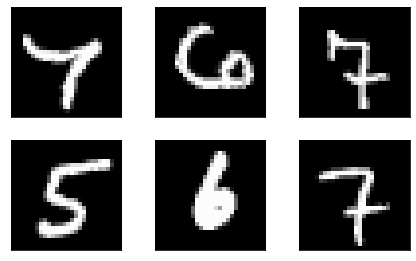

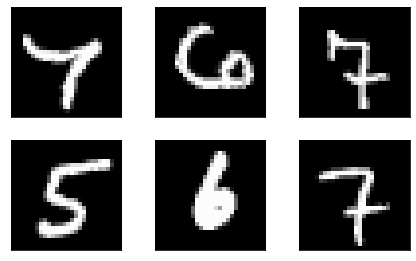

In [48]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Create Neural Network

In [49]:
class Net(nn.Module):
    def __init__(self, hidden_size, use_relu):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(28*28*1, hidden_size)
        self.output = torch.nn.Linear(hidden_size, 10)
        self.use_relu = use_relu

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = x.flatten(start_dim = 1)
        
        if self.use_relu:
          x = F.leaky_relu(self.hidden(x))#.clamp(min=0)
        else:
          x = F.softmax(self.hidden(x))

        x = F.log_softmax(self.output(x))
        return x

In [50]:
def defineNetwork(hidden_size, use_relu):
  global network
  network = Net(hidden_size, use_relu)
  if GPU_ON:
    network.cuda()
    
  global optimizer
  optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [51]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      if GPU_ON:
        data = data.cuda()
        target = target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
  return ('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  

In [52]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    if GPU_ON:
      data = data.cuda()
      target = target.cuda()
    output = network(data)
    loss = F.nll_loss(output, target)
    #F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [53]:
def createPlot(activation_function, time):
  temp = plt.figure()
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel("%s" % (network)+" "+ activation_function+ " "+time)
  plt.ylabel('negative log likelihood loss')
  plt.plot(train_counter, train_losses, color='blue')
  plt.close()
  return temp

# Training

##### Training GPU VS *CPU*

In [54]:

#CPU:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = False
defineNetwork(100, True)

CPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
results.append(test())


CPU_time = time.time() - CPU_time

plot = createPlot("Relu as Activation","CPU: %s seconds" % (CPU_time))
figures.append(plot)

#GPU
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
results.append(test())

GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

print("--- CPU: %s seconds ---" % (CPU_time))
print("--- GPU: %s seconds ---" % (GPU_time))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.018225
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.028831
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.004506
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.013335
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.003922
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.006093
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.034395
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.008652
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.010197
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.009236
Train Epoch: 49 [42240/60000 (70%)]	Loss: 0.012379
Train Epoch: 49 [42880/60000 (71%)]	Loss: 0.007104
Train Epoch: 49 [43520/60000 (72%)]	Loss: 0.009870
Train Epoch: 49 [44160/60000 (74%)]	Loss: 0.009943
Train Epoch: 49 [44800/60000 (75%)]	Loss: 0.007893
Train Epoch: 49 [45440/60000 (76%)]	Loss: 0.013322
Train Epoch: 49 [46080/60000 (77%)]	Loss: 0.038775
Train Epoch: 49 [46720/60000 (78%)]	Loss: 0.002436
Train Epoch: 49

##### Training SoftMax 100 & 1000 Layers

In [55]:
#softmax 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, False)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Softmax as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#softmax 1000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(1000, False)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Softmax as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.667243
Train Epoch: 49 [35200/60000 (59%)]	Loss: 0.857180
Train Epoch: 49 [35840/60000 (60%)]	Loss: 1.162013
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.832246
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.792179
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.769465
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.658134
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.710693
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.891316
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.784675
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.769936
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.972206
Train Epoch: 49 [42240/60000 (70%)]	Loss: 0.785281
Train Epoch: 49 [42880/60000 (71%)]	Loss: 0.775682
Train Epoch: 49 [43520/60000 (72%)]	Loss: 0.991007
Train Epoch: 49 [44160/60000 (74%)]	Loss: 0.730850
Train Epoch: 49 [44800/60000 (75%)]	Loss: 0.738630
Train Epoch: 49 [45440/60000 (76%)]	Loss: 0.913515
Train Epoch: 49

##### 100, 1000 & 10 000 Layers

In [56]:
#Relu 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#Relu 1000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(1000, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#Relu 10000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(10000, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.003809
Train Epoch: 49 [35200/60000 (59%)]	Loss: 0.010493
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.004860
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.008014
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.005910
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.001610
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.004245
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.006435
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.005497
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.014606
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.013920
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.004539
Train Epoch: 49 [42240/60000 (70%)]	Loss: 0.006044
Train Epoch: 49 [42880/60000 (71%)]	Loss: 0.009368
Train Epoch: 49 [43520/60000 (72%)]	Loss: 0.009611
Train Epoch: 49 [44160/60000 (74%)]	Loss: 0.008847
Train Epoch: 49 [44800/60000 (75%)]	Loss: 0.001938
Train Epoch: 49 [45440/60000 (76%)]	Loss: 0.004606
Train Epoch: 49

# Evaluation

##### GPU VS CPU


Test set: Avg. loss: 0.0756, Accuracy: 9796/10000 (98%)



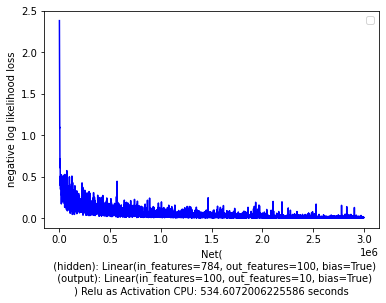

In [57]:
print(results[0])
figures[0]


Test set: Avg. loss: 0.0725, Accuracy: 9794/10000 (98%)



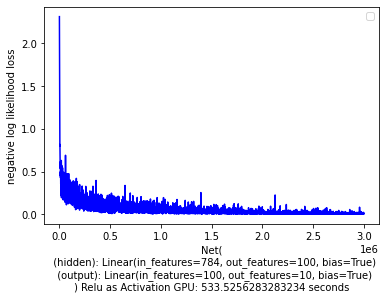

In [58]:
print(results[1])
figures[1]

##### Softmax


Test set: Avg. loss: 0.8194, Accuracy: 7533/10000 (75%)



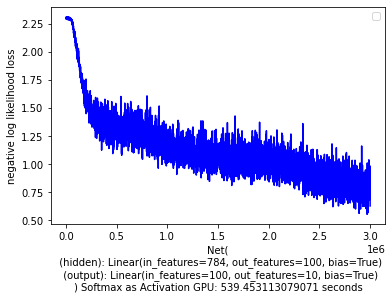

In [59]:
print(results[2])
figures[2]


Test set: Avg. loss: 0.9130, Accuracy: 6408/10000 (64%)



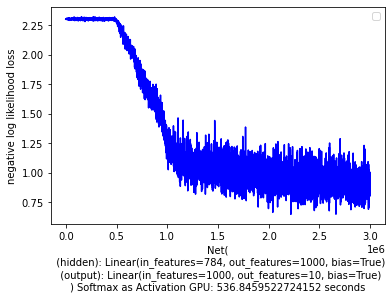

In [60]:
print(results[3])
figures[3]

Die Outputs der Softmax Funktion sind in Summe 1. So sind die Änderungen immer kleiner je mehr Neuronen es in einem Layer gibt. Folge: Das Netzwerk lernt langsammer als mit der Relu Funktion, welche die Änderungsrate nicht begrenzt.

Mögliche Lösung: Beim Verwenden von Softmax die Learning-Rate erhöhen. Dies erschwert aber die Suche nach einem lokalen Minimum.

##### Relu 100, 1000, 10 000


Test set: Avg. loss: 0.0699, Accuracy: 9810/10000 (98%)



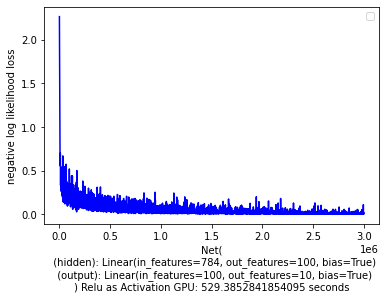

In [61]:
print(results[4])
figures[4]


Test set: Avg. loss: 0.0590, Accuracy: 9813/10000 (98%)



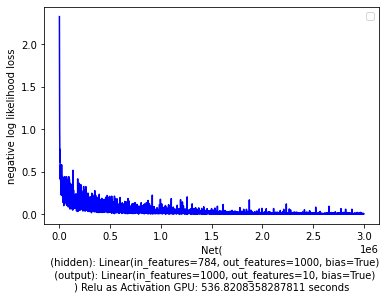

In [62]:
print(results[5])
figures[5]


Test set: Avg. loss: 0.0577, Accuracy: 9834/10000 (98%)



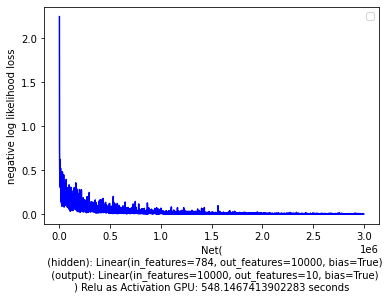

In [63]:
print(results[6])
figures[6]